## Import Tools

In [1]:
import torch
import torch.nn as nn
import numpy as np
import scipy.io
import random
import math
import matplotlib.pyplot as plt
import torch.nn.functional as F
import os
import seaborn as sn
import pandas as pd
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score

## Dataset Processing

### Read in the original dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dataset = '/content/drive/MyDrive/Project 1/Dataset/'
train_dl_origin = torch.load(dataset+'train_dl.pt')
valid_dl_origin = torch.load(dataset+'valid_dl.pt')

train_CSI = train_dl_origin.dataset[:][0]
train_label = train_dl_origin.dataset[:][1][:,2].type(torch.LongTensor)

valid_CSI = valid_dl_origin.dataset[:][0]
valid_label = valid_dl_origin.dataset[:][1][:,2].type(torch.LongTensor)

### CSI Processing: Take Modulus of complex matrices

In [4]:
train_CSI_modulus = torch.abs(train_CSI)
valid_CSI_modulus = torch.abs(valid_CSI)

In [5]:
print(train_CSI_modulus.shape)
print(valid_CSI_modulus.shape)

torch.Size([15000, 1, 4, 1632])
torch.Size([5000, 1, 4, 1632])


###  CSI Processing: Normalize to [0,1]

In [6]:
from torchvision import transforms

# You would typically calculate these values from the training set
mean = train_CSI_modulus.mean()
std = train_CSI_modulus.std()

# Then create a transform to normalize the data
normalize = transforms.Normalize(mean.tolist(), std.tolist())

# Apply the transform to your data
# Note: You need to make sure your data is in the form of a tensor before you can apply the transform
train_CSI_modulus_normalized = normalize(train_CSI_modulus)
valid_CSI_modulus_normalized = normalize(valid_CSI_modulus)


In [7]:
print(train_CSI_modulus_normalized.shape)
print(valid_CSI_modulus_normalized.shape)

torch.Size([15000, 1, 4, 1632])
torch.Size([5000, 1, 4, 1632])


KNN Classifier

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Reshape the data to 2D array (samples, features) for scikit-learn
train_data_flat = train_CSI_modulus_normalized.reshape(train_CSI_modulus_normalized.shape[0], -1)
valid_data_flat = valid_CSI_modulus_normalized.reshape(valid_CSI_modulus_normalized.shape[0], -1)

# Ensure the data is in numpy format
train_data_flat_np = train_data_flat.numpy()
valid_data_flat_np = valid_data_flat.numpy()

# Ensure the labels are also flattened if they are one-hot encoded or in tensor format
# If they are already flat and in numpy format, you can skip this step
train_labels_np = train_label.numpy().flatten()
valid_labels_np = valid_label.numpy().flatten()

# Initialize the KNeighborsClassifier
# You can change the number of neighbors and other parameters as needed
knn = KNeighborsClassifier(n_neighbors=3)

# Fit the model on the training data
knn.fit(train_data_flat_np, train_labels_np)

# Predict the labels on validation dataset
predictions = knn.predict(valid_data_flat_np)

# Evaluate the model
accuracy = accuracy_score(valid_labels_np, predictions)

print(f'Validation Accuracy: {accuracy}')


Validation Accuracy: 0.9996


Confusion Matrix:
 [[4064    0]
 [   2  934]]


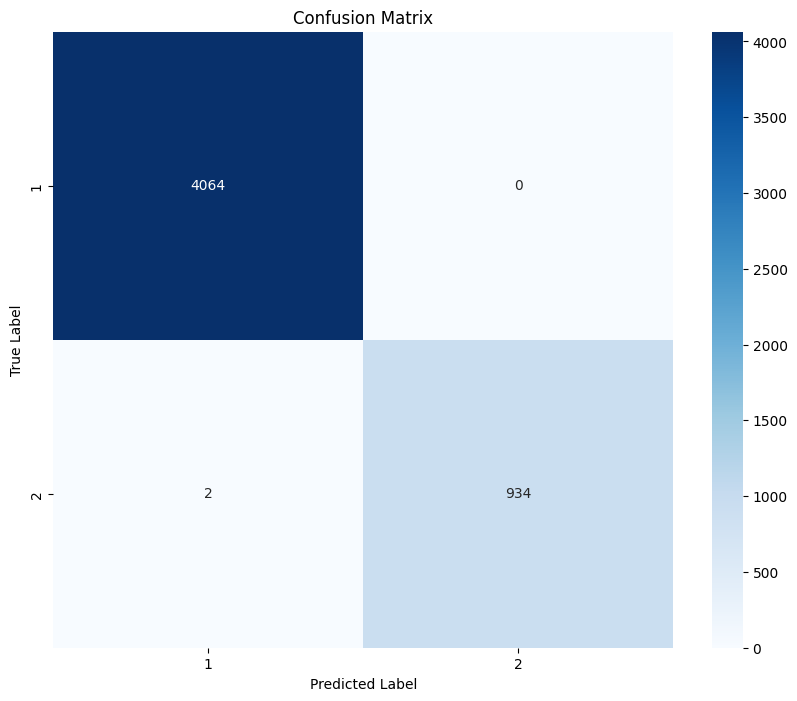

Precision per class: [0.99950812 1.        ]
Recall per class: [1.         0.99786325]
F1 score per class: [0.999754   0.99893048]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4064
           1       1.00      1.00      1.00       936

    accuracy                           1.00      5000
   macro avg       1.00      1.00      1.00      5000
weighted avg       1.00      1.00      1.00      5000

Overall Precision: 0.999754058042302
Overall Recall: 0.9989316239316239
Overall F1 Score: 0.9993422394116989


In [18]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# ... (after fitting the KNN model and predicting the labels)

# Confusion Matrix
conf_matrix = confusion_matrix(valid_labels_np, predictions)
print("Confusion Matrix:\n", conf_matrix)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(1, 3), yticklabels=range(1, 3))
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Precision, Recall, F1 scores for each class
precision = precision_score(valid_labels_np, predictions, average=None)
recall = recall_score(valid_labels_np, predictions, average=None)
f1 = f1_score(valid_labels_np, predictions, average=None)

print(f'Precision per class: {precision}')
print(f'Recall per class: {recall}')
print(f'F1 score per class: {f1}')

# A combined report with all the above metrics
classification_report = classification_report(valid_labels_np, predictions)
print("Classification Report:\n", classification_report)

# To get the overall average precision, recall, and F1-score (not per class)
precision_overall = precision_score(valid_labels_np, predictions, average='macro')
recall_overall = recall_score(valid_labels_np, predictions, average='macro')
f1_overall = f1_score(valid_labels_np, predictions, average='macro')

print(f'Overall Precision: {precision_overall}')
print(f'Overall Recall: {recall_overall}')
print(f'Overall F1 Score: {f1_overall}')


ANN Method

In [12]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam

# Assuming you have train_CSI_modulus_normalized, valid_CSI_modulus_normalized, train_labels, and valid_labels

# Flatten the data
train_data_flat = train_CSI_modulus_normalized.reshape(train_CSI_modulus_normalized.shape[0], -1)
valid_data_flat = valid_CSI_modulus_normalized.reshape(valid_CSI_modulus_normalized.shape[0], -1)

# Create Dataset objects
train_dataset = TensorDataset(train_data_flat, train_label)
valid_dataset = TensorDataset(valid_data_flat, valid_label)

# Create DataLoaders
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=64, shuffle=False)

# Define the ANN model
class ANNModel(nn.Module):
    def __init__(self):
        super(ANNModel, self).__init__()
        self.fc1 = nn.Linear(train_data_flat.shape[1], 128)  # Assuming the flattened size is the second dimension
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 10)  # Change the number 10 to the number of classes you have

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)  # No activation, as it will be included in the loss function
        return x

# Initialize the model
model = ANNModel()

# Define a loss function and optimizer
criterion = nn.CrossEntropyLoss()  # For classification problems with N classes
optimizer = Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 10  # Set the number of epochs
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    for inputs, targets in train_loader:
        optimizer.zero_grad()  # Zero the gradient buffers
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, targets)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

# Evaluate the model
model.eval()  # Set the model to evaluation mode
all_predictions = []
all_targets = []
with torch.no_grad():  # Gradient computation is not needed for evaluation
    for inputs, targets in valid_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)  # Get the class with the highest output
        all_predictions.extend(predicted.numpy())
        all_targets.extend(targets.numpy())

# Calculate validation accuracy
accuracy = (np.array(all_predictions) == np.array(all_targets)).mean()
print(f'Validation Accuracy: {accuracy}')


Epoch 1/10, Loss: 0.11276081949472427
Epoch 2/10, Loss: 0.1809563785791397
Epoch 3/10, Loss: 0.13016720116138458
Epoch 4/10, Loss: 0.13642017543315887
Epoch 5/10, Loss: 0.05558006465435028
Epoch 6/10, Loss: 0.034663669764995575
Epoch 7/10, Loss: 0.09539517760276794
Epoch 8/10, Loss: 0.008803298696875572
Epoch 9/10, Loss: 0.028042078018188477
Epoch 10/10, Loss: 0.05815742909908295
Validation Accuracy: 0.9502


Showing the ANN model

In [15]:
from graphviz import Digraph

def draw_model():
    dot = Digraph(format='png')
    dot.attr(rankdir='LR')  # Left to Right Graph

    # Nodes
    dot.node('Input', 'Input\n(1x4x1632)')
    dot.node('FC1', 'FC1\n(128)')
    dot.node('ReLU1', 'ReLU')
    dot.node('FC2', 'FC2\n(64)')
    dot.node('ReLU2', 'ReLU')
    dot.node('FC3', 'FC3\n(32)')
    dot.node('ReLU3', 'ReLU')
    dot.node('Output', 'Output\n(10)')

    # Edges
    dot.edge('Input', 'FC1')
    dot.edge('FC1', 'ReLU1')
    dot.edge('ReLU1', 'FC2')
    dot.edge('FC2', 'ReLU2')
    dot.edge('ReLU2', 'FC3')
    dot.edge('FC3', 'ReLU3')
    dot.edge('ReLU3', 'Output')

    return dot

# Call the function and render the diagram
dot = draw_model()
dot.render('ann_model_diagram')


'ann_model_diagram.png'

Precision per class: [0.94226756 1.        ]
Recall per class: [1.         0.73397436]
F1 score per class: [0.97027576 0.84658041]
Overall Precision: 0.9711337815905402
Overall Recall: 0.8669871794871795
Overall F1 Score: 0.9084280808489578
Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      4064
           1       1.00      0.73      0.85       936

    accuracy                           0.95      5000
   macro avg       0.97      0.87      0.91      5000
weighted avg       0.95      0.95      0.95      5000

Confusion Matrix:
 [[4064    0]
 [ 249  687]]


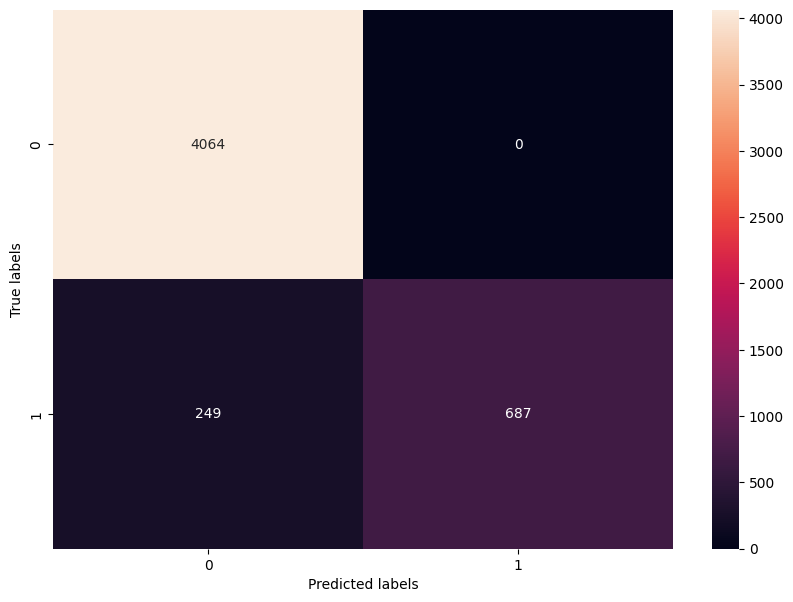

In [20]:
from sklearn.metrics import classification_report

# Assuming you have all_predictions and all_targets from your ANN predictions

# Calculate precision, recall, and F1 score for each class
precision_per_class = precision_score(all_targets, all_predictions, average=None)
recall_per_class = recall_score(all_targets, all_predictions, average=None)
f1_per_class = f1_score(all_targets, all_predictions, average=None)

# Calculate overall precision, recall, and F1 score
precision_overall = precision_score(all_targets, all_predictions, average='macro')
recall_overall = recall_score(all_targets, all_predictions, average='macro')
f1_overall = f1_score(all_targets, all_predictions, average='macro')

# Print the metrics for each class
print(f'Precision per class: {precision_per_class}')
print(f'Recall per class: {recall_per_class}')
print(f'F1 score per class: {f1_per_class}')

# Print the overall metrics
print(f'Overall Precision: {precision_overall}')
print(f'Overall Recall: {recall_overall}')
print(f'Overall F1 Score: {f1_overall}')

# Generate the classification report
report = classification_report(all_targets, all_predictions)
print("Classification Report:\n", report)

# Confusion Matrix
conf_matrix = confusion_matrix(all_targets, all_predictions)
print('Confusion Matrix:\n', conf_matrix)

# Visual representation of the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()
